# FnGuide 마켓 데이터 전처리

- 시가총액, 거래대금 기준 top 100에 드는 종목만 universe로 남길 예정

In [4]:
from pathlib import Path
import pandas as pd

In [5]:
CWD = Path.cwd()
WORKSPACE_PATH = CWD.parent
COMMON_PATH = WORKSPACE_PATH / 'common'
DATA_PATH = WORKSPACE_PATH / 'data'

## 데이터 불러오기 & 전처리

In [6]:
filename = 'DataGuide_KSE+KOSDAQ_20200101-20240729_ALL.xlsx'

df = pd.read_excel(DATA_PATH / filename, skiprows=8,)

In [7]:
ticker_to_name = df[['Symbol', 'Symbol Name']].drop_duplicates().set_index('Symbol').to_dict()['Symbol Name']

In [8]:
name_to_tick = {v: k for k, v in ticker_to_name.items()}  

In [9]:
item_aliases = ['close', 'returns', 'moneyvolume', 'marketcap', 'beta1y']

itemkor_to_eng = dict(zip(df['Item Name '].drop_duplicates().to_list(), item_aliases))
itemeng_to_kor = {v: k for k, v in itemkor_to_eng.items()}

In [10]:
df.drop(columns=['Symbol Name', 'Kind', 'Item', 'Frequency', ], inplace=True)

In [11]:
df.columns

Index([           'Symbol',        'Item Name ', 2020-01-02 00:00:00,
       2020-01-03 00:00:00, 2020-01-06 00:00:00, 2020-01-07 00:00:00,
       2020-01-08 00:00:00, 2020-01-09 00:00:00, 2020-01-10 00:00:00,
       2020-01-13 00:00:00,
       ...
       2024-07-16 00:00:00, 2024-07-17 00:00:00, 2024-07-18 00:00:00,
       2024-07-19 00:00:00, 2024-07-22 00:00:00, 2024-07-23 00:00:00,
       2024-07-24 00:00:00, 2024-07-25 00:00:00, 2024-07-26 00:00:00,
       2024-07-29 00:00:00],
      dtype='object', length=1131)

In [12]:
df = df.melt(id_vars=['Symbol', 'Item Name '], var_name='Date', value_name='Value', )

In [13]:
df

,Symbol,Item Name,Date,Value
0,A005930,수정주가(원),2020-01-02 00:00:00,5.520000e+04
1,A005930,수익률(%),2020-01-02 00:00:00,-1.080000e+00
2,A005930,거래대금(원),2020-01-02 00:00:00,7.196632e+11
3,A005930,시가총액 (티커-상장예정주식수 포함)(백만원),2020-01-02 00:00:00,3.295320e+08
4,A005930,"베타 (D,1Yr)",2020-01-02 00:00:00,1.479140e+00
...,...,...,...,...
21038910,A950180,수정주가(원),2024-07-29 00:00:00,NaN
21038911,A950180,수익률(%),2024-07-29 00:00:00,NaN
21038912,A950180,거래대금(원),2024-07-29 00:00:00,NaN
21038913,A950180,시가총액 (티커-상장예정주식수 포함)(백만원),2024-07-29 00:00:00,NaN


In [14]:
df.columns = ['Symbol', 'ItemEng', 'Date', 'Value']
df['ItemEng'] = df['ItemEng'].map(itemkor_to_eng)

In [15]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [16]:
df

,Symbol,ItemEng,Date,Value
0,A005930,close,2020-01-02,5.520000e+04
1,A005930,returns,2020-01-02,-1.080000e+00
2,A005930,moneyvolume,2020-01-02,7.196632e+11
3,A005930,marketcap,2020-01-02,3.295320e+08
4,A005930,beta1y,2020-01-02,1.479140e+00
...,...,...,...,...
21038910,A950180,close,2024-07-29,NaN
21038911,A950180,returns,2024-07-29,NaN
21038912,A950180,moneyvolume,2024-07-29,NaN
21038913,A950180,marketcap,2024-07-29,NaN


In [17]:
df.to_pickle(DATA_PATH / 'stock_data_ALL.pkl') # 전처리 끝난 level 1 data

In [18]:
returns_df = df[df['ItemEng'] == 'returns'].pivot_table(index='Date', columns='Symbol', values='Value', aggfunc='first')


In [19]:
returns_df = returns_df / 100

In [20]:
moneyvolume_df = df[df['ItemEng'] == 'moneyvolume'].pivot_table(index='Date', columns='Symbol', values='Value', aggfunc='first')


In [21]:
marketcap_df = df[df['ItemEng'] == 'marketcap'].pivot_table(index='Date', columns='Symbol', values='Value', aggfunc='first')

In [22]:
returns_df.to_pickle(DATA_PATH / 'returns_df_ALL.pkl') # 전처리 끝난 전체 유니버스 데이터들
moneyvolume_df.to_pickle(DATA_PATH / 'moneyvolume_df_ALL.pkl')
marketcap_df.to_pickle(DATA_PATH / 'marketcap_df_ALL.pkl')

<Axes: xlabel='Date'>

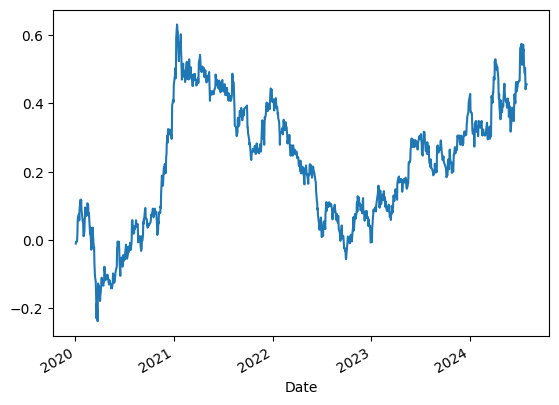

In [23]:
((returns_df['A005930'] + 1).cumprod() - 1).plot() # 삼성전자 주가 확인

## Top 100 필터링

In [24]:
moneyvolume_df_top100_mask = moneyvolume_df.rank(axis=1, method='first', ascending=False) <= 100

In [25]:
marketcap_df_top100_mask = marketcap_df.rank(axis=1, method='first', ascending=False) <= 100

In [26]:
universe_df_top100_mask = (moneyvolume_df_top100_mask * marketcap_df_top100_mask)

In [27]:
universe_df_top100_list = (moneyvolume_df_top100_mask * marketcap_df_top100_mask).any(axis=0)
universe_df_top100_list

Symbol
A000020    False
A000040    False
A000050    False
A000060     True
A000070    False
           ...  
A950180    False
A950190    False
A950200    False
A950210    False
A950220    False
Length: 2732, dtype: bool

In [28]:
returns_df_top100 = returns_df.loc[:, universe_df_top100_list].copy()

In [29]:
returns_df_top100.to_pickle(DATA_PATH / 'returns_df_top100.pkl')

In [30]:
returns_df_top100

Symbol,A000060,A000080,A000100,A000120,A000150,A000210,A000250,A000270,A000660,A000720,...,A373220,A377300,A383220,A402340,A403870,A417200,A443060,A450080,A454910,A462870
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,-0.0392,-0.0034,-0.0211,-0.0161,-0.0199,-0.0298,0.0211,-0.0406,0.0064,-0.0260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.0000,-0.0121,-0.0043,-0.0295,-0.0087,0.0000,-0.0316,-0.0118,-0.0021,-0.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,-0.0292,0.0035,-0.0174,-0.0068,-0.0249,-0.0421,-0.0327,-0.0024,-0.0021,-0.0366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,-0.0150,-0.0070,0.0177,0.0000,-0.0045,0.0131,-0.0059,0.0036,-0.0032,0.0051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,-0.0152,-0.0264,-0.0195,-0.0238,-0.0226,-0.0305,-0.0428,-0.0178,0.0362,-0.0516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-23,NaN,0.0074,0.0031,0.0208,0.0463,-0.0110,0.0081,0.0397,0.0000,-0.0212,...,-0.0076,-0.0781,-0.0324,-0.0117,-0.0187,-0.0240,0.0789,-0.0078,0.0477,-0.0277
2024-07-24,NaN,0.0000,0.0103,0.0311,-0.0418,0.0130,-0.0096,-0.0174,0.0171,-0.0077,...,-0.0138,0.0040,0.0128,-0.0106,-0.0381,-0.0172,0.0000,-0.0358,-0.0443,-0.0676
2024-07-25,NaN,-0.0123,-0.0235,-0.0156,-0.1179,-0.0092,-0.0605,-0.0287,-0.0887,0.0031,...,0.0342,0.0341,-0.0126,-0.0406,-0.0076,-0.0350,0.0038,-0.0035,-0.0802,0.0692


종가 데이터 추가 (서비스 화면 위해)

In [32]:
close_df = df[df['ItemEng'] == 'close'].pivot_table(index='Date', columns='Symbol', values='Value', aggfunc='first')

In [33]:
close_df_top100 = close_df.loc[:, universe_df_top100_list].copy()

<Axes: xlabel='Date'>

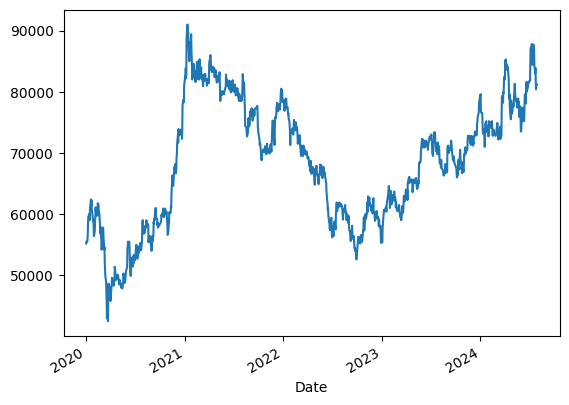

In [35]:
close_df_top100['A005930'].plot()

In [36]:
close_df_top100.to_pickle(DATA_PATH / 'close_df_top100.pkl')